In [28]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import json
import time
from collections import Counter
from collections import defaultdict

In [29]:
def read_json_file(filename):
    with open(filename, 'r') as file:
        return json.load(file)


records = read_json_file("./output.json")

print(records[0])

{'id': '2151505206', 'friends': []}


=== Базова інформація про мережу ===
Кількість вузлів: 1731
Кількість ребер: 12729
Щільність графа: 0.0085

=== Аналіз компонент зв'язності ===
Кількість компонент зв'язності: 1
Розмір найбільшої компоненти: 1731

=== Статистика степенів вузлів ===
Мінімальний степінь: 1
Максимальний степінь: 139
Середній степінь: 14.71
Перший квартиль степені: 4.00
Медіана степені: 9.00
Третій квартиль степінь: 22.00

=== Метрики централізації ===
Степенева централізація: 0.0719


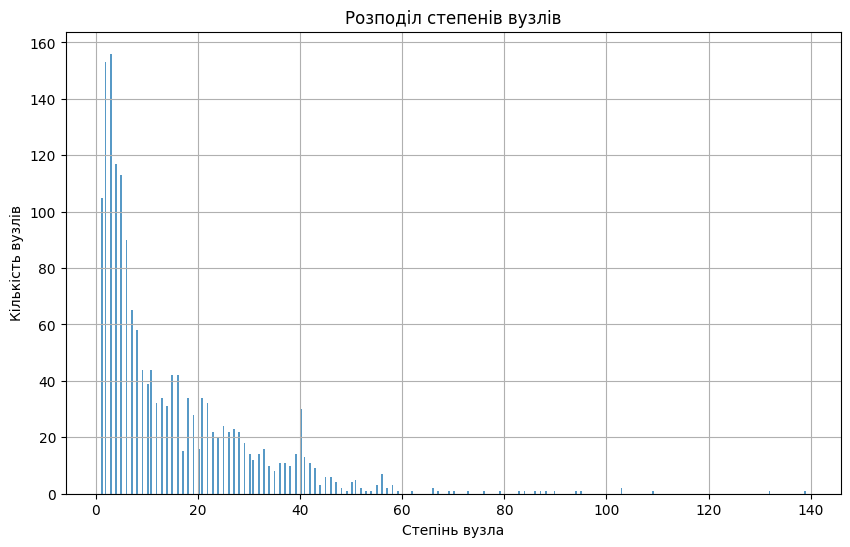

In [30]:
# creating Graph

def create_graph():
    g = nx.Graph()

    for record in records:
        g.add_node(record['id'])

    for record in records:
        for friend in record['friends']:
            g.add_edge(record['id'], friend)

    return g


g = create_graph()

print("=== Базова інформація про мережу ===")
print(f"Кількість вузлів: {g.number_of_nodes()}")
print(f"Кількість ребер: {g.number_of_edges()}")
print(f"Щільність графа: {nx.density(g):.4f}")

components = list(nx.connected_components(g))
print(f"\n=== Аналіз компонент зв'язності ===")
print(f"Кількість компонент зв'язності: {len(components)}")
print(f"Розмір найбільшої компоненти: {len(max(components, key=len))}")

degrees = [d for n, d in g.degree()]
print("\n=== Статистика степенів вузлів ===")
print(f"Мінімальний степінь: {min(degrees)}")
print(f"Максимальний степінь: {max(degrees)}")
print(f"Середній степінь: {sum(degrees) / len(degrees):.2f}")
print(f"Перший квартиль степені: {np.percentile(degrees, 25):.2f}")
print(f"Медіана степені: {np.percentile(degrees, 50):.2f}")
print(f"Третій квартиль степінь: {np.percentile(degrees, 75):.2f}")

print("\n=== Метрики централізації ===")
max_degree = max(degrees)
n = len(g)
degree_centralization = (sum(max_degree - d for d in degrees)) / ((n - 1) * (n - 2))
print(f"Степенева централізація: {degree_centralization:.4f}")

plt.figure(figsize=(10, 6))
degree_count = Counter(degrees)
plt.hist(degrees, bins=400, alpha=0.75)
plt.xlabel('Степінь вузла')
plt.ylabel('Кількість вузлів')
plt.title('Розподіл степенів вузлів')
plt.grid(True)
plt.show()

In [31]:
def apply_metric(g, n, metric):
    g.remove_nodes_from(sorted(metric, key=metric.get, reverse=True)[:n])

    return g

def lazy_calc(fn):
    result = None

    def lazy_call(g):
        nonlocal result
        if result is None:
            result = fn(g)

        return result

    return lazy_call

betweennessLazy = lazy_calc(nx.betweenness_centrality)
closenessLazy = lazy_calc(nx.closeness_centrality)
eigenvectorLazy = lazy_calc(nx.eigenvector_centrality_numpy)
clusteringLazy = lazy_calc(nx.clustering)

def random(g, n):
    nodes = list(g.nodes())
    nodes_to_remove = np.random.choice(nodes, size=n, replace=False)
    g.remove_nodes_from(nodes_to_remove)
    return g

def degree(g, n):
    return apply_metric(g, n, dict(g.degree()))

def betweenness(g, n):
    return apply_metric(g, n, betweennessLazy(g))


def closeness(g, n):
    return apply_metric(g, n, closenessLazy(g))


def eigenvector(g, n):
    return apply_metric(g, n, eigenvectorLazy(g))


def clustering(g, n):
    return apply_metric(g, n, clusteringLazy(g))


def combined(g, n):
    degrees = dict(g.degree())
    closeness = clusteringLazy(g)

    max_degree = max(degrees.values())
    degrees = {k: v / max_degree for k, v in degrees.items()}

    combined_metric = {
        node: 0.5 * degrees[node] + 0.5 * closeness[node]
        for node in g.nodes()
    }

    return apply_metric(g, n, combined_metric)

def attack_strategies(g, fraction_to_remove=0.5, steps=50):
    results = defaultdict(list)
    fractions = np.linspace(0, fraction_to_remove, steps)

    initial_size = len(max(nx.connected_components(g), key=len))

    strategies = {
        'Видалення методом random': random,
        'Видалення методом degree': degree,
        'Видалення методом betweenness': betweenness,
        'Видалення методом closeness': closeness,
        'Видалення методом eigenvector': eigenvector,
        'Видалення методом clustering': clustering,
        'Комбінований метод degree + closeness': combined
    }

    for name, strategy in strategies.items():
        start_time = time.time()

        print(f"\nВиконується атака: {name}")

        for f in fractions:
            g_after_atack = strategy(g.copy(), int(f * g.number_of_nodes()))
            largest_cc = len(max(nx.connected_components(g_after_atack), key=len))

            results[name].append(largest_cc / initial_size)

        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Час виконання: {execution_time:.4f} секунд")


    return results, fractions


results, fractions = attack_strategies(create_graph())


Виконується атака: Видалення методом random
Час виконання: 1.0602 секунд

Виконується атака: Видалення методом degree
Час виконання: 1.0724 секунд

Виконується атака: Видалення методом betweenness
Час виконання: 9.5663 секунд

Виконується атака: Видалення методом closeness
Час виконання: 3.6487 секунд

Виконується атака: Видалення методом eigenvector
Час виконання: 1.0795 секунд

Виконується атака: Видалення методом clustering
Час виконання: 1.1020 секунд

Виконується атака: Комбінований метод degree + closeness
Час виконання: 1.0003 секунд



Критичні пороги для різних стратегій:
Видалення методом random: 0.900
Видалення методом degree: 0.740
Видалення методом betweenness: 0.640
Видалення методом closeness: 0.760
Видалення методом eigenvector: 0.860
Видалення методом clustering: 0.940
Комбінований метод degree + closeness: 0.880


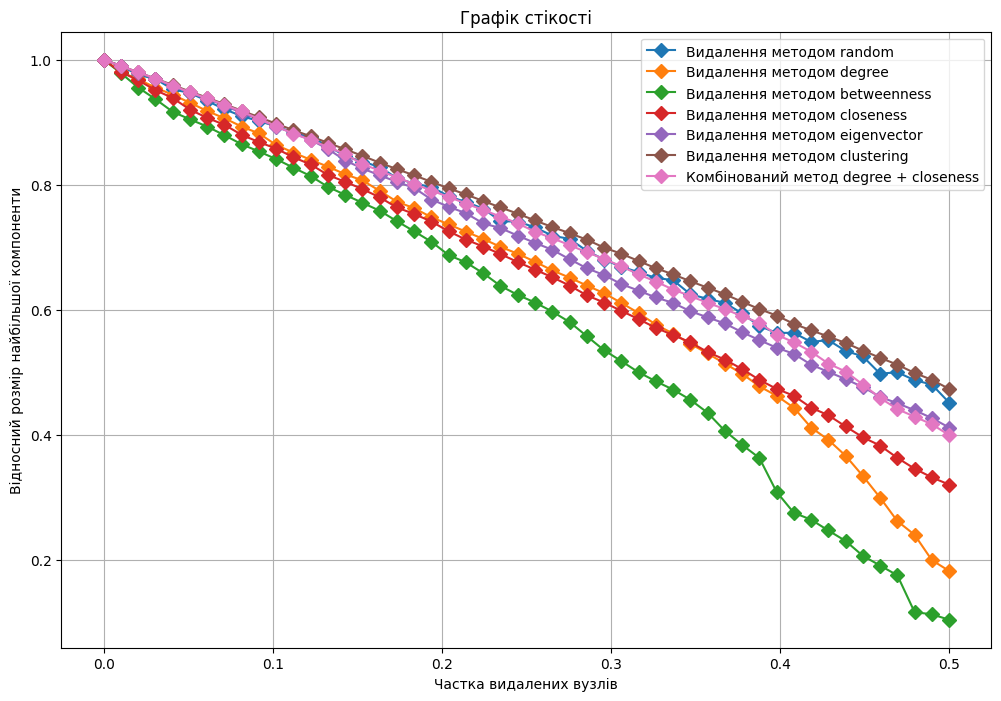

In [32]:
def find_critical_threshold(results):
    thresholds = {}
    for strategy, values in results.items():
        for i, value in enumerate(values):
            if value < 0.5:
                thresholds[strategy] = i / len(values)
                break

    return thresholds


def plot_results(results, fractions):
    plt.figure(figsize=(12, 8))

    for strategy, values in results.items():
        plt.plot(fractions, values, label=strategy, marker='D', markersize=7)

    plt.xlabel('Частка видалених вузлів')
    plt.ylabel('Відносний розмір найбільшої компоненти')
    plt.title('Графік стікості')
    plt.grid(True)
    plt.legend()
    plt.show()

print("\nКритичні пороги для різних стратегій:")
for strategy, threshold in find_critical_threshold(results).items():
    print(f"{strategy}: {threshold:.3f}")

plot_results(results, fractions)